# Scenario visualisation

_Note: For full compatibility, use Python >= 3.6 to run this notebook._

This notebook shows you how to visualize the scenario as graph. It allows you to better understand the problem. 

Please ensure that you first install the following Python libraries:
- networkx
- matplotlib

## Example

_Note: The following code is also collected in_ [this](utils/route_graph.py) _script_

Setup config:

In [1]:
import json
import networkx as nx
import time
import pathlib
import tempfile
import matplotlib.pyplot as plt

This function returns "from"-node id based on a given route_section, so that the graph can be constructed correctly. 

In [2]:
def from_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_entry" in route_section.keys() and \
            route_section["route_alternative_marker_at_entry"] is not None and \
            len(route_section["route_alternative_marker_at_entry"]) > 0:
                return "(" + str(route_section["route_alternative_marker_at_entry"][0]) + ")"
    else:
        if index_in_path == 0:  # can only get here if this node is a very beginning of a route
            return "(" + str(route_section["sequence_number"]) + "_beginning)"
        else:
            return "(" + (str(route_path["route_sections"][index_in_path - 1]["sequence_number"]) + "->" +
                          str(route_section["sequence_number"])) + ")"

This function returns "to"-node id based on a given route_section, so that the graph can be constructed correctly. 

In [3]:
def to_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_exit" in route_section.keys() and \
            route_section["route_alternative_marker_at_exit"] is not None and \
            len(route_section["route_alternative_marker_at_exit"]) > 0:

                return "(" + str(route_section["route_alternative_marker_at_exit"][0]) + ")"
    else:
        if index_in_path == (len(route_path["route_sections"]) - 1): # meaning this node is a very end of a route
            return "(" + str(route_section["sequence_number"]) + "_end" + ")"
        else:
            return "(" + (str(route_section["sequence_number"]) + "->" +
                          str(route_path["route_sections"][index_in_path + 1]["sequence_number"])) + ")"

We read the scenario file and based on the two functions above build the graph, by looping through the different routes, choosing getting the from and to node from the two functions mentioned before.  

In [4]:
scenario = "../sample_files/sample_scenario.json"
with open(scenario) as fp:
    scenario = json.load(fp)
    
start_time = time.time()

# now build the graph. Nodes are called "previous_FAB -> next_FAB" within lineare abschnittsfolgen and "AK" if
# there is an Abschnittskennzeichen 'AK' on it
route_graphs = dict()
for route in scenario["routes"]:

    # set global graph settings
    G = nx.DiGraph(route_id = route["id"], name="Route-Graph for route "+str(route["id"]))

    # add edges with data contained in the preprocessed graph
    for path in route["route_paths"]:
        for (i, route_section) in enumerate(path["route_sections"]):
            sn = route_section['sequence_number']
            print("Adding Edge from {} to {} with sequence number {}".format(from_node_id(path, route_section, i), to_node_id(path, route_section, i), sn))

            G.add_edge(from_node_id(path, route_section, i),
                       to_node_id(path, route_section, i),
                       sequence_number=sn)

    route_graphs[route["id"]] = G

print("Finished building fahrweg-graphen in {} seconds".format(str(time.time() - start_time)))

Adding Edge from (1_beginning) to (M1) with sequence number 1
Adding Edge from (M1) to (4->5) with sequence number 4
Adding Edge from (4->5) to (M2) with sequence number 5
Adding Edge from (M2) to (M3) with sequence number 6
Adding Edge from (M3) to (10->13) with sequence number 10
Adding Edge from (10->13) to (M4) with sequence number 13
Adding Edge from (M4) to (14_end) with sequence number 14
Adding Edge from (2_beginning) to (M1) with sequence number 2
Adding Edge from (3_beginning) to (M1) with sequence number 3
Adding Edge from (M2) to (7->8) with sequence number 7
Adding Edge from (7->8) to (8->9) with sequence number 8
Adding Edge from (8->9) to (9_end) with sequence number 9
Adding Edge from (M3) to (11->12) with sequence number 11
Adding Edge from (11->12) to (M4) with sequence number 12
Adding Edge from (1_beginning) to (M1) with sequence number 1
Adding Edge from (M1) to (4->5) with sequence number 4
Adding Edge from (4->5) to (M2) with sequence number 5
Adding Edge from (M

At last the graph is being plotted as an image and saved to graphml. The plotting might not be as easy to unterstand. This is the reason for outputing graphml files which will allow you to visualize the graph in a tool of your choice.

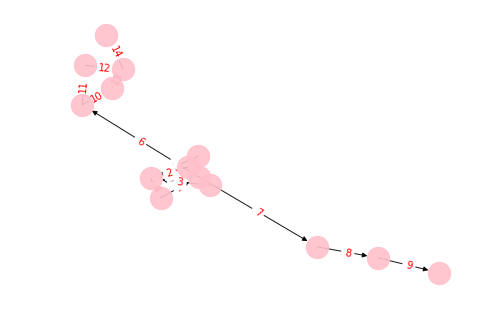

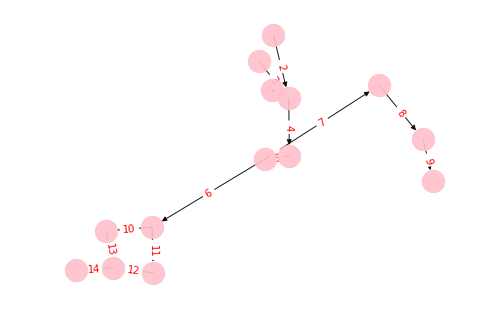

In [5]:
for k, route_graph in route_graphs.items():
    for node in route_graph.nodes():
        route_graph.node[node]['label'] = node

    edge_labels = {}
    for node1, node2, data in route_graph.edges(data=True):
        edge_labels[(node1, node2)] = data['sequence_number'] 

    for edge in route_graph.edges():
        route_graph.edges[edge]['label'] = edge_labels[edge]

    pos = nx.spring_layout(route_graph)
    nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
    nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
    nx.write_graphml(route_graph, "graph-"+str(k)+".graphml")
    plt.show()

And this what it looks like after processing the graphml with [yED](https://www.yworks.com/products/yed/download). Labels on the edges represent the sequence_number. In some cases the cleaned version of the grpah does not render properly. Find the image [here](https://gitlab.crowdai.org/SBB/train-schedule-optimisation-challenge-starter-kit/raw/master/utils/img/graph-111.png)

![](https://gitlab.crowdai.org/SBB/train-schedule-optimisation-challenge-starter-kit/raw/master/utils/img/graph-111.png)